In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm
import yaml

def swarm_from_bins(y, bin_step=30, x_base=0):
    sort_idx = np.argsort(y)
    y = y.iloc[sort_idx]
    get_org_idx = np.argsort(sort_idx)
    
    hist, bins = np.histogram(y, bin_step)
    bin_size = (np.max(y)-np.min(y))/bin_step
    
    x = np.zeros_like(y)
    for i in range(len(bins)-1):
        y_in_bin = np.bitwise_and(y >= bins[i], y < bins[i+1])
        y_i = y[y_in_bin]
        if len(y_i) > 1:
            cumsum_steps = np.cumsum(np.repeat(bin_size, len(y_i)))
            x_i = cumsum_steps-(cumsum_steps[-1]/2)-bin_size/2
            x_i = x_i[np.argsort(abs(x_i))]
            x[y_in_bin] = x_i
    x = x[get_org_idx]+x_base
    y = y.iloc[get_org_idx]
    return x

In [ ]:
config_path = "TRN_config.yml"
config = yaml.safe_load(open(config_path, "r"))

exp = config['filesettings']['experiment']
datestr = config['filesettings']['date']
mov_path = os.path.join(config['filesettings']['videopath'], exp)
inpath = os.path.join(config['filesettings']['outpath'], exp, datestr)

info = pd.read_csv(os.path.join(inpath, config['filesettings']['fileinfo']), index_col='plate')
list_movies = list(info.index)
first_mov = np.sort(list_movies)[0].replace(exp,'')
last_mov = np.sort(list_movies)[-1].replace(exp,'')
file_str = f'{exp}_{first_mov}-{last_mov}_mask_{datestr}'

In [23]:
calcium_peaks = pd.read_csv(os.path.join(inpath, f'{file_str}_peak_height.csv'), index_col=[0,1])
calcium_peaks.columns

Index(['wormID', 't_stim', 'peak_height', 'velo_peakheight', 'reversal',
       'max_angle', 'mean_prestim_angle', 'mean_velocity',
       'mean_prestim_velocity', 'sig_mean_poststim'],
      dtype='object')

/tmp/ipykernel_212758/3543136783.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for val, group in grouped:


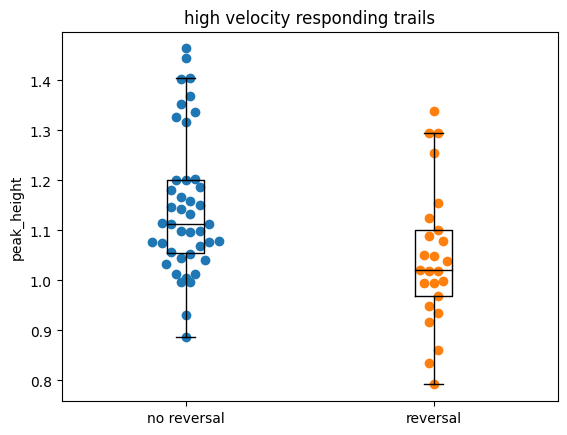

In [24]:
grouped = calcium_peaks.groupby(['reversal'])
rev_label = {0: 'no reversal', 1: 'reversal'}
for val, group in grouped:
    plt.boxplot(group.loc[:,'sig_mean_poststim'], positions=[val], showfliers=False, medianprops={'color':'k'})
    plt.scatter(swarm_from_bins(group.loc[:,'sig_mean_poststim'], bin_step=15, x_base=val), group.loc[:,'sig_mean_poststim']);
plt.xticks([0,1],rev_label.values())
plt.ylabel('peak_height')
plt.title('high velocity responding trails');

In [28]:
calcium_peaks = calcium_peaks.reset_index(drop=True)
calcium_peaks.columns

Index(['wormID', 't_stim', 'peak_height', 'velo_peakheight', 'reversal',
       'max_angle', 'mean_prestim_angle', 'mean_velocity',
       'mean_prestim_velocity', 'sig_mean_poststim'],
      dtype='object')

In [41]:
DF = calcium_peaks[calcium_peaks.notnull().any(axis=1)]
# Fit the mixed linear model
model = mixedlm(
    "peak_height ~ C(reversal)", # main hypothesis the mean signal after stimualtion is influenced by worms doing a reversal 
    groups='wormID', 
    data=DF
)

peak_result = model.fit(reml=True)
summary_text = peak_result.summary().as_text()
with open(os.path.join(inpath, f'{file_str}_mixedlmResult.txt'), 'w') as f:
    f.write(summary_text)
result.summary()

/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/sklearn-env2/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: sig_mean_poststim
No. Observations: 68      Method:             REML             
No. Groups:       18      Scale:              0.0150           
Min. group size:  1       Log-Likelihood:     35.0410          
Max. group size:  5       Converged:          Yes              
Mean group size:  3.8                                          
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.150    0.026 44.363 0.000  1.099  1.201
C(reversal)[T.1]     -0.096    0.033 -2.944 0.003 -0.160 -0.032
wormID Var            0.005    0.028                           
===============================================================

"""

In [42]:
DF = calcium_peaks[calcium_peaks.notnull().any(axis=1)]
# Fit the mixed linear model
model = mixedlm(
    "sig_mean_poststim ~ C(reversal)", # main hypothesis the mean signal after stimualtion is influenced by worms doing a reversal 
    groups='wormID', 
    data=DF
)

post_result = model.fit(reml=True)
summary_text = post_result.summary().as_text()
with open(os.path.join(inpath, f'{file_str}_mixedlmResult.txt'), 'a') as f:
    f.write(summary_text)
result.summary()

/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/sklearn-env2/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: sig_mean_poststim
No. Observations: 68      Method:             REML             
No. Groups:       18      Scale:              0.0150           
Min. group size:  1       Log-Likelihood:     35.0410          
Max. group size:  5       Converged:          Yes              
Mean group size:  3.8                                          
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.150    0.026 44.363 0.000  1.099  1.201
C(reversal)[T.1]     -0.096    0.033 -2.944 0.003 -0.160 -0.032
wormID Var            0.005    0.028                           
===============================================================

"""

/tmp/ipykernel_212758/975414890.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for val, group in grouped:


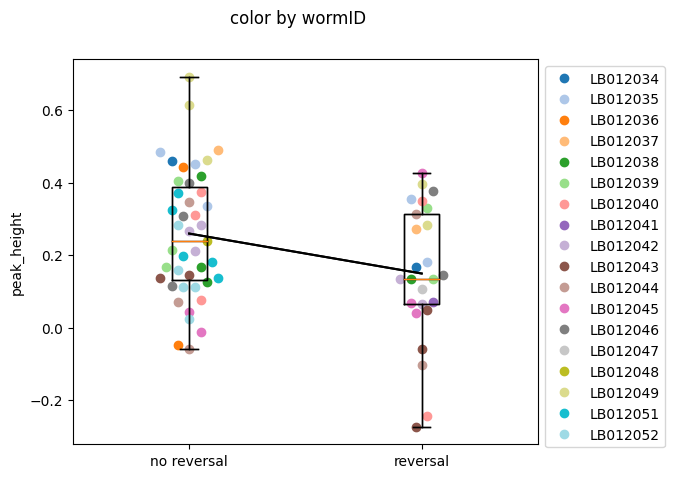

/tmp/ipykernel_212758/975414890.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for val, group in grouped:


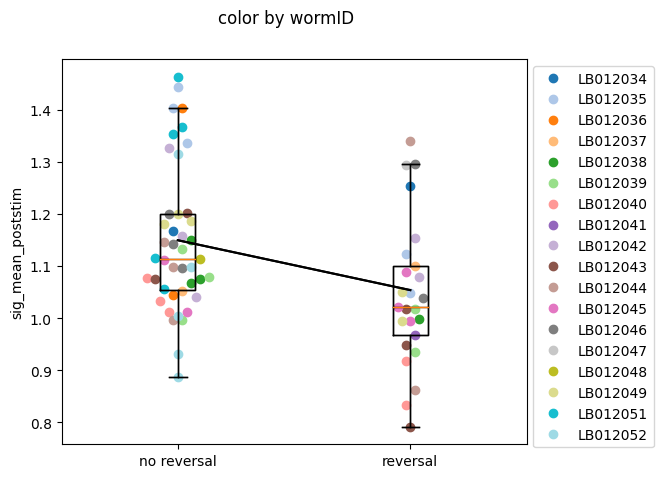

In [58]:
for feat, result in zip(['peak_height','sig_mean_poststim'],[peak_result, post_result]):
    params = pd.DataFrame(result.params).T
    
    fig, ax = plt.subplots(1, figsize=(6,5))
    grouped = DF.groupby(['reversal'])
    
    for val, group in grouped:
        min_f = np.min(calcium_peaks.loc[:,'reversal'])
        max_f = np.max(calcium_peaks.loc[:,'reversal'])
        for p in params:
            if 'reversal' in p:
                f_coef = params[p]
        line = [params['Intercept'] + min_f * f_coef , 
                params['Intercept'] + max_f * f_coef ]
        ax.plot([min_f, max_f], line, color='k')
        
        plt.boxplot(group.loc[:,feat], positions=[val], showfliers=False, medianprops={'color':'k'})
        x_loc = swarm_from_bins(group.loc[:,feat], bin_step=15, x_base=val)
        for w in worm_color:
            plt.scatter(x_loc[group['wormID']==w], group.loc[:,feat][group['wormID']==w], color=worm_color[w], label=w)
        
        ax.boxplot(group.loc[:,feat], positions=[val], showfliers=False, zorder=2)
    ax.set_xticks([0,1],['no reversal','reversal'])
    ax.set_ylabel(feat)
    fig.suptitle('color by wormID')
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in worm_color.values()]
    plt.legend(markers, worm_color.keys(), numpoints=1, bbox_to_anchor=(1,1))
    featstr = ''.join(feat.split('_'))
    plt.savefig(os.path.join(inpath, f"{file_str}_{featstr}.pdf"))
    plt.show()